In [40]:
using XLSX
using DataFrames
using Plots

# Ruta a tu archivo Excel
file_path = "C:/Users/FERNANDO/Downloads/Districtwise_literacy_rates.xlsx"

# Cargar la primera hoja (por defecto es la primera hoja del libro)
df = XLSX.readtable(file_path, 1) |> DataFrame


Row,STATCD,DISTCD,STATNAME,DISTNAME,DISTRICTS,BLOCKS,VILLAGES,TOTPOPULAT,P_URB_POP,POPULATION_0_6,GROWTHRATE,SEXRATIO,P_SC_POP,P_ST_POP,OVERALL_LI,FEMALE_LIT,MALE_LIT,AREA_SQKM,TOT_6_10_15,TOT_11_13_15,SCH1,SCH2,SCH3,SCH4,SCH5,SCH6,SCH7,SCH9,SCHTOT,SCH1G,SCH2G,SCH3G,SCH4G,SCH5G,SCH6G,SCH7G,SCH9G,SCHTOTG,SCH1P,SCH2P,SCH3P,SCH4P,SCH5P,SCH6P,SCH7P,SCH9P,SCHTOTP,SCH1GR,SCH2GR,SCH3GR,SCH4GR,SCH5GR,SCH6GR,SCH7GR,SCH9GR,SCHTOTGR,SCH1PR,SCH2PR,SCH3PR,SCH4PR,SCH5PR,SCH6PR,SCH7PR,SCH9PR,SELE1,SELE2,SELE3,SELE4,SELE5,SELE6,SELE7,SCOMP1,SCOMP2,SCOMP3,SCOMP4,SCOMP5,SCOMP6,SCOMP7,ENR501,ENR502,ENR503,ENR504,ENR505,ENR506,ENR507,ENR509,CLS1,CLS2,CLS3,CLS4,CLS5,CLS6,CLS7,TCH1,TCH2,TCH3,TCH4,TCH5,TCH6,TCH7
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,101,JAMMU & KASHMIR,KUPWARA,1,13,391,875564,11.33,1.97002e5,34.62,843,0.12,8.08,66.92,54.79,77.1,2379,135672,72701,1107,818,2,14,2,84,49,0,2076,980,697,1,14,2,49,49,0,1792,127,121,1,0,0,35,0,0,284,954,681,1,14,2,48,49,0,1749,117,114,0,0,0,23,0,0,44,69,2,8,1,40,25,23,92,1,1,1,39,16,933,237,1,13,1,8,27,43,3489,5315,27,62,23,852,239,2708,5205,43,70,28,1065,638
2,1,102,JAMMU & KASHMIR,BARAMULA,1,18,678,1015503,17.19,1.61871e5,20.34,873,0.15,3.74,66.93,55.01,77.35,4243,117874,70952,1215,825,9,11,5,176,69,0,2310,1108,639,1,11,5,96,69,0,1929,107,186,8,0,0,80,0,0,381,1031,600,1,8,5,91,60,0,1796,98,160,4,0,0,58,0,0,278,330,9,7,5,132,57,24,123,7,0,4,85,26,1014,240,0,10,4,35,49,41,4127,5800,210,53,30,1665,360,2937,5873,236,60,105,2533,964
3,1,103,JAMMU & KASHMIR,SRINAGAR,1,8,94,1269751,98.73,1.55798e5,23.56,879,0.09,0.72,71.21,63.47,77.95,1979,113560,62397,258,417,36,2,0,263,9,0,985,203,209,1,2,0,65,9,0,489,55,208,35,0,0,198,0,0,496,18,6,0,0,0,6,0,0,30,4,14,0,0,0,1,0,0,96,212,36,0,0,253,8,38,209,36,0,0,213,2,227,161,3,2,0,38,7,30,817,3284,886,11,0,2873,40,828,3647,1159,14,0,4757,129
4,1,104,JAMMU & KASHMIR,BADGAM,1,13,523,735753,11.74,1.50756e5,21.18,883,0.05,3.17,57.98,46.6,68.56,1361,118477,58838,755,537,10,10,1,98,57,0,1468,697,423,1,10,1,40,57,0,1229,56,114,9,0,0,58,0,0,237,678,411,0,10,1,40,54,0,1194,55,110,8,0,0,49,0,0,70,78,10,2,1,64,25,19,100,9,3,1,68,15,654,137,0,8,0,15,38,43,2290,3837,119,45,8,1035,325,1878,3892,250,68,19,1493,716
5,1,105,JAMMU & KASHMIR,PULWAMA,1,8,359,570060,13.8,97651.3,29.18,913,0.07,4.03,65,53.81,75.41,1086,64493,30166,532,339,4,14,2,94,43,0,1028,497,233,0,14,2,23,43,0,812,35,106,4,0,0,71,0,0,216,470,215,0,13,2,23,41,0,764,27,88,0,0,0,48,0,0,29,76,4,3,2,76,35,18,89,4,1,2,69,13,501,125,0,13,1,6,35,36,1688,2584,151,67,5,1101,209,1336,2682,113,90,38,1414,506
6,1,106,JAMMU & KASHMIR,ANANTNAG,1,12,523,1070144,26.04,2.06324e5,37.48,937,0.17,10.75,64.32,54.15,74.13,3574,150600,78343,779,869,10,14,5,160,48,0,1885,691,682,2,14,5,72,48,0,1514,88,187,8,0,0,88,0,0,371,626,619,2,12,5,66,43,0,1373,77,147,4,0,0,60,0,0,52,131,10,5,5,122,43,56,172,10,1,2,90,13,696,349,0,13,3,16,39,50,2650,5862,152,60,22,1592,185,2084,6182,261,74,95,2491,597
7,1,107,JAMMU & KASHMIR,LEH (LADAKH),1,6,110,147104,42.96,11812.5,25.48,583,0.37,71.81,80.48,64.52,89.39,45110,9066,5260,176,145,3,3,2,46,0,0,375,144,126,1,3,2,32,0,0,308,32,19,2,0,0,14,0,0,67,138,121,0,3,2,31,0,0,295,29,13,1,0,0,9,0,0,30,34,3,0,2,42,0,19,84,3,2,2,41,0,174,119,0,3,0,29,0,14,604,1059,45,9,17,473,0,470,1160,62,19,45,813,0
8,1,108,JAMMU & KASHMIR,KARGIL,1,7,134,143388,8.89,20404.1,20.18,775,0.01,86.89,74.49,58.05,86.73,14036,15468,8377,229,289,6,6,1,27,28,0,586,213,260,1,6,1,18,27,0,526,16,29,5,0,0,9,1,0,60,204,249,1,6,1,18,24,0,503,12,23,2,0,0,6,0,0,4,14,6,5,1,8,7,19,67,6,2,1,19,16,220,234,0,6,0,13,27,16,716,1469,69,26,3,220,99,471,1582,90,44,17,274,288
9,1,109,JAMMU & KASHMIR,DODA,1,10,38

In [41]:
# Suponiendo que ya cargaste el DataFrame como `df`
original_rows = nrow(df)

# Eliminar filas con al menos un valor faltante (equivalente a dropna(how="any"))
df_clean = dropmissing(df)

println("Original rows: ", original_rows)
println("Rows after dropping missing values: ", nrow(df_clean))

Original rows: 680
Rows after dropping missing values: 625


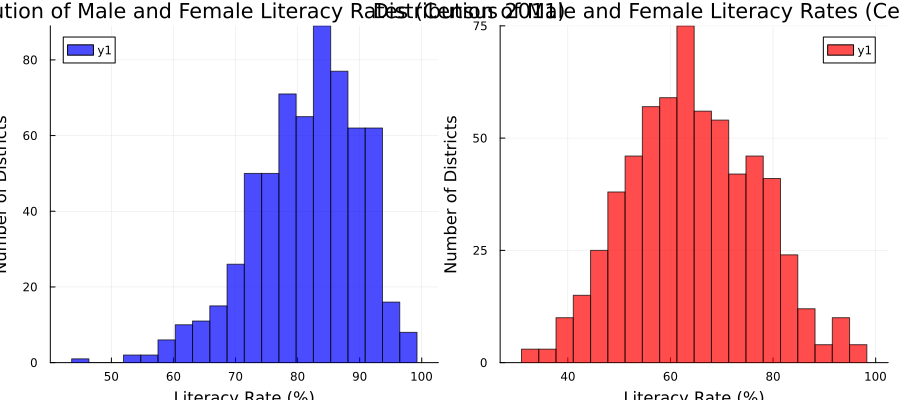

In [42]:
# 5️⃣ Histogramas
male_lit   = df_clean[!, :MALE_LIT]
female_lit = df_clean[!, :FEMALE_LIT]

plt1 = histogram(
    male_lit,
    bins =   range(minimum(male_lit), stop = maximum(male_lit), length = 21),
    color = :blue,
    linecolor = :black,
    alpha = 0.7,
    xlabel = "Literacy Rate (%)",
    ylabel = "Number of Districts",
    title = "Male Literacy Rate"
)

plt2 = histogram(
    female_lit,
    bins =  range(minimum(female_lit), stop = maximum(female_lit), length = 21),
    color = :red,
    linecolor = :black,
    alpha = 0.7,
    xlabel = "Literacy Rate (%)",
    ylabel = "Number of Districts",
    title = "Female Literacy Rate"
)

plot(
    plt1,
    plt2,
    layout = (1, 2),
    size   = (900, 400),
    title  = "Distribution of Male and Female Literacy Rates (Census 2011)"
)

In [52]:
using DataFrames, GLM, Random, Statistics

# Variables predictoras
X_cols = [:TOTPOPULAT, :P_URB_POP, :SEXRATIO, :P_SC_POP, :P_ST_POP]
X = select(df_clean, X_cols...)

# Combinar X con la variable objetivo
data = copy(X)
insertcols!(data, :FEMALE_LIT => df_clean[!, :FEMALE_LIT])

# Train/Test Split 75/25
Random.seed!(42)
n = nrow(data)
idx = shuffle(1:n)                    # mezcla aleatoria de índices
train_size = round(Int, 0.75 * n)     # 75% para entrenamiento
train_idx = idx[1:train_size]
test_idx  = idx[train_size+1:end]

train_df = data[train_idx, :]
test_df  = data[test_idx, :]

for col in [:TOTPOPULAT, :P_URB_POP, :SEXRATIO, :P_SC_POP, :P_ST_POP, :FEMALE_LIT]
    try
        df_clean[!, col] = convert.(Float64, df_clean[!, col])
    catch e
        println("Error al convertir la columna $col: ", e)
    end
end
modelo=GLM.lm(@formula(FEMALE_LIT ~ TOTPOPULAT + P_URB_POP + SEXRATIO + P_SC_POP + P_ST_POP) , train_df)

println("Resumen del modelo:")
println(modelo)

# Predicciones en el conjunto de prueba
y_pred = GLM.predict(modelo, test_df)
y_true = test_df[!, :FEMALE_LIT]

# Calcular métricas
mse = mean((y_true .- y_pred).^2)
println("MSE en el conjunto de prueba: ", mse)
r2 = cor(y_true, y_pred)^2
println("R² en el conjunto de prueba: ", r2)

# Visualización: Gráfico de dispersión con línea de referencia
scatter(y_true, y_pred, label="Predicciones vs. Reales", xlabel="FEMALE_LIT (Real)", ylabel="FEMALE_LIT (Predicho)", title="Ajuste del Modelo de Regresión Lineal")
plot!(y_true, y_true, label="Línea de referencia (y=x)", color=:red, linestyle=:dash)
savefig("line_fitting_plot.png")

Resumen del modelo:
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

FEMALE_LIT ~ 1 + TOTPOPULAT + P_URB_POP + SEXRATIO + P_SC_POP + P_ST_POP

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  30.8741      7.64316      4.04    <1e-04  15.8545      45.8937
TOTPOPULAT   -5.66493e-7  3.66481e-7  -1.55    0.1228  -1.28667e-6   1.5368e-7
P_URB_POP     0.32925     0.0291711   11.29    <1e-25   0.271926     0.386575
SEXRATIO      0.0296568   0.00783431   3.79    0.0002   0.0142616    0.0450521
P_SC_POP     -0.0544094   0.0695955   -0.78    0.4347  -0.191172     0.0823529
P_ST_POP     -0.0321858   0.0257563   -1.25    0.2121  -0.0827995    0.

"c:\\Users\\FERNANDO\\AppData\\Local\\Programs\\Microsoft VS Code\\line_fitting_plot.png"

In [60]:
using DataFrames, GLM, Random, Statistics, MLJ, MLJModels, Plots

# Función para generar características polinómicas de grado 2 (cuadrados + interacciones)
function polynomial_features(df::DataFrame, cols::Vector{Symbol}; degree=2)
    result = copy(df)
    # Términos cuadrados
    for col in cols
        result[!, Symbol("$(col)_sq")] = result[!, col] .^ 2
    end
    # Interacciones entre pares de columnas
    for i in 1:length(cols)
        for j in i+1:length(cols)
            col1, col2 = cols[i], cols[j]
            result[!, Symbol("$(col1)_x_$(col2)")] = result[!, col1] .* result[!, col2]
        end
    end
    return result
end

# --- Target y predictores ---
target = :FEMALE_LIT
predictors = [:TOTPOPULAT, :P_URB_POP, :SEXRATIO, :P_SC_POP, :P_ST_POP, :AREA_SQKM]

# Verificar tipos de datos
println("Tipos de datos en df_clean: ", eltype.(eachcol(df_clean[!, [predictors..., target]])))

# --- Train/test split ---
Random.seed!(42)
X = select(df_clean, predictors)
y = df_clean[!, target]
n = nrow(X)
idx = shuffle(1:n)
train_size = round(Int, 0.75 * n)
train_idx = idx[1:train_size]
test_idx = idx[train_size+1:end]

X_train = X[train_idx, :]
X_test = X[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

# --- Generar características polinómicas ---
X_train_poly = polynomial_features(X_train, predictors; degree=2)
X_test_poly = polynomial_features(X_test, predictors; degree=2)

# --- Estandarizar los datos ---
scaler = Standardizer()
mach_scaler = machine(scaler, X_train_poly)
fit!(mach_scaler)
X_train_scaled = MLJ.transform(mach_scaler, X_train_poly)
X_test_scaled = MLJ.transform(mach_scaler, X_test_poly)

# --- Ajustar el modelo de regresión lineal ---
# Crear la fórmula dinámicamente con las columnas de X_train_scaled
predictor_cols = names(X_train_scaled)
formula_terms = [Term(target), [Term(col) for col in Symbol.(predictor_cols)]...]
formula = FormulaTerm(formula_terms[1], tuple(formula_terms[2:end]...))

# Combinar X_train_scaled con y_train para GLM.lm
train_data = hcat(X_train_scaled, DataFrame(FEMALE_LIT=y_train))
model = GLM.lm(formula, train_data)

# --- Predicciones y métricas ---
y_pred = GLM.predict(model, X_test_scaled)
r2 = cor(y_test, y_pred)^2
mse = mean((y_test .- y_pred).^2)
n_in = length(predictors)
n_out = length(predictor_cols)

println("Especificación de alta dimensionalidad (flexible):")
println("- Predictores base ($n_in): $predictors")
println("- Características expandidas (grado=2: cuadrados + interacciones): $n_out")
println("- Test R²: $(round(r2, digits=4))")
println("- Test MSE: $(round(mse, digits=4))")

# --- Visualización: Gráfico de dispersión con línea de referencia ---
scatter(y_test, y_pred, label="Predicciones vs. Reales", xlabel="FEMALE_LIT (Real)", ylabel="FEMALE_LIT (Predicho)", title="Ajuste del Modelo Polinómico (Grado 2)")
plot!(y_test, y_test, label="Línea de referencia (y=x)", color=:red, linestyle=:dash)
savefig("polynomial_line_fitting_plot.png")

Tipos de datos en df_clean: DataType[Float64, Float64, Float64, Float64, Float64, Float64, Float64]


[ Info: Training machine(Standardizer(features = Symbol[], …), …).


Especificación de alta dimensionalidad (flexible):
- Predictores base (6): [:TOTPOPULAT, :P_URB_POP, :SEXRATIO, :P_SC_POP, :P_ST_POP, :AREA_SQKM]
- Características expandidas (grado=2: cuadrados + interacciones): 27
- Test R²: 0.4149
- Test MSE: 98.6225


"c:\\Users\\FERNANDO\\AppData\\Local\\Programs\\Microsoft VS Code\\polynomial_line_fitting_plot.png"

In [71]:
using DataFrames

# --- Target y predictores ---
target = :FEMALE_LIT
demographic = [:TOTPOPULAT, :P_URB_POP, :POPULATION_0_6, :GROWTHRATE, :SEXRATIO, :P_SC_POP, :P_ST_POP, :AREA_SQKM, :TOT_6_10_15, :TOT_11_13_15]
sch_gov = [:SCH2G, :SCH3G, :SCH4G, :SCH5G, :SCH6G, :SCH7G]
sch_priv = [:SCH2P, :SCH3P, :SCH4P, :SCH5P, :SCH6P, :SCH7P]
sch_gov_rur = [:SCH2GR, :SCH3GR, :SCH4GR, :SCH5GR, :SCH6GR, :SCH7GR]
sch_priv_rur = [:SCH2PR, :SCH3PR, :SCH4PR, :SCH5PR, :SCH6PR, :SCH7PR]
sele = [:SELE2, :SELE3, :SELE4, :SELE5, :SELE6, :SELE7]
scomp = [:SCOMP2, :SCOMP3, :SCOMP4, :SCOMP5, :SCOMP6, :SCOMP7]
enr50 = [:ENR502, :ENR503, :ENR504, :ENR505, :ENR506, :ENR507]
cls = [:CLS2, :CLS3, :CLS4, :CLS5, :CLS6, :CLS7]
tch = [:TCH2, :TCH3, :TCH4, :TCH5, :TCH6, :TCH7]

base_predictors = vcat(demographic, sch_gov, sch_priv, sch_gov_rur, sch_priv_rur, sele, scomp, enr50, cls, tch)

# Verificar nombres de columnas en df_clean
println("Columnas disponibles en df_clean: ", names(df_clean))

# Convertir nombres de columnas a símbolos si son strings
df_clean_names = Symbol.(names(df_clean))

# Verificar columnas existentes y faltantes
existing = [c for c in base_predictors if c in df_clean_names]
missing_cols = [c for c in base_predictors if c ∉ df_clean_names]
if !isempty(missing_cols)
    println("[warning] Missing variables skipped: ", missing_cols)
end
if isempty(existing)
    error("No predictors available in df_clean. Check column names.")
end

# Crear DataFrame con target y predictores existentes
dfm = select(df_clean, [target; existing])

# Convertir todas las columnas predictoras a Float64
for col in [target; existing]
    if eltype(dfm[!, col]) != Float64
        try
            dfm[!, col] = convert.(Float64, dfm[!, col])
        catch e
            println("Error converting column $col to Float64: ", e)
            error("Failed to convert column $col to Float64.")
        end
    end
end

# Verificar tipos de datos después de conversión
println("Tipos de datos en dfm: ", eltype.(eachcol(dfm)))

# --- Crear términos no lineales (cuadrados e interacciones) ---
square_cols = [:P_URB_POP, :SEXRATIO, :P_SC_POP, :P_ST_POP, :TOTPOPULAT, :AREA_SQKM]
interaction_pairs = [
    (:P_URB_POP, :SEXRATIO),
    (:P_URB_POP, :P_SC_POP),
    (:P_URB_POP, :P_ST_POP),
    (:SELE2, :SCOMP2),
    (:CLS2, :TCH2)
]

# Función para generar términos no lineales
function add_nonlinear_terms(df::DataFrame, square_cols::Vector{Symbol}, interaction_pairs::Vector{Tuple{Symbol,Symbol}})
    result = copy(df)
    # Términos cuadrados
    for col in square_cols
        if col in names(result)
            result[!, Symbol("$(col)_sq")] = result[!, col] .^ 2
        end
    end
    # Interacciones específicas
    for (col1, col2) in interaction_pairs
        if col1 in names(result) && col2 in names(result)
            result[!, Symbol("$(col1)_x_$(col2)")] = result[!, col1] .* result[!, col2]
        end
    end
    return result
end

dfm = add_nonlinear_terms(dfm, square_cols, interaction_pairs)

# Verificar columnas finales en dfm
println("Columnas finales en dfm: ", names(dfm))

Columnas disponibles en df_clean: ["STATCD", "DISTCD", "STATNAME", "DISTNAME", "DISTRICTS", "BLOCKS", "VILLAGES", "TOTPOPULAT", "P_URB_POP", "POPULATION_0_6", "GROWTHRATE", "SEXRATIO", "P_SC_POP", "P_ST_POP", "OVERALL_LI", "FEMALE_LIT", "MALE_LIT", "AREA_SQKM", "TOT_6_10_15", "TOT_11_13_15", "SCH1", "SCH2", "SCH3", "SCH4", "SCH5", "SCH6", "SCH7", "SCH9", "SCHTOT", "SCH1G", "SCH2G", "SCH3G", "SCH4G", "SCH5G", "SCH6G", "SCH7G", "SCH9G", "SCHTOTG", "SCH1P", "SCH2P", "SCH3P", "SCH4P", "SCH5P", "SCH6P", "SCH7P", "SCH9P", "SCHTOTP", "SCH1GR", "SCH2GR", "SCH3GR", "SCH4GR", "SCH5GR", "SCH6GR", "SCH7GR", "SCH9GR", "SCHTOTGR", "SCH1PR", "SCH2PR", "SCH3PR", "SCH4PR", "SCH5PR", "SCH6PR", "SCH7PR", "SCH9PR", "SELE1", "SELE2", "SELE3", "SELE4", "SELE5", "SELE6", "SELE7", "SCOMP1", "SCOMP2", "SCOMP3", "SCOMP4", "SCOMP5", "SCOMP6", "SCOMP7", "ENR501", "ENR502", "ENR503", "ENR504", "ENR505", "ENR506", "ENR507", "ENR509", "CLS1", "CLS2", "CLS3", "CLS4", "CLS5", "CLS6", "CLS7", "TCH1", "TCH2", "TCH3", "T

In [76]:

using DataFrames, GLM, Random, Statistics, MLJ, MLJModels, StatsModels, StatisticalTraits

# --- Definir X, y ---
target = :FEMALE_LIT
predictors = [c for c in names(dfm) if c != target]
if isempty(predictors)
    error("No predictors available in dfm. Check column names.")
end
println("Número de predictores: ", length(predictors))
println("Predictores: ", predictors)

X = select(dfm, predictors)
y = dfm[!, target]

# Convertir y a Float64 si no lo es
if eltype(y) != Float64
    try
        y = convert.(Float64, y)
    catch e
        println("Error converting target $target to Float64: ", e)
        error("Failed to convert target $target to Float64.")
    end
end

# Verificar tipos de datos en X
println("Tipos de datos en X: ", eltype.(eachcol(X)))

# --- Train/test split ---
Random.seed!(42)
n = nrow(X)
idx = shuffle(1:n)
train_size = round(Int, 0.75 * n)
train_idx = idx[1:train_size]
test_idx = idx[train_size+1:end]

X_train = X[train_idx, :]
X_test = X[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]

# --- Estandarizar los datos ---
scaler = Standardizer()
mach_scaler = machine(scaler, X_train)
fit!(mach_scaler)
X_train_scaled = MLJ.transform(mach_scaler, X_train)
X_test_scaled = MLJ.transform(mach_scaler, X_test)

# --- Ajustar el modelo de regresión lineal ---
# Definir schema explícitamente para tratar predictores como continuos
schema_dict = Dict(col => StatisticalTraits.Continuous for col in Symbol.(names(X_train_scaled)))
sch = StatsModels.schema(X_train_scaled, schema_dict)

# Crear fórmula dinámicamente
formula_terms = [Term(target), [Term(col) for col in Symbol.(names(X_train_scaled))]...]
formula = FormulaTerm(formula_terms[1], tuple(formula_terms[2:end]...))

# Combinar X_train_scaled con y_train, asegurando nombres únicos
train_data = hcat(X_train_scaled, DataFrame(y_train=y_train), makeunique=true)
model = GLM.lm(formula, train_data)

# --- Predicciones y métricas ---
y_pred = GLM.predict(model, X_test_scaled)
r2 = cor(y_test, y_pred)^2

println("\n=== Wide model with squares + selected interactions ===")
println("n_features: ", length(names(X_train_scaled)))
println("Test R²: ", round(r2, digits=4))

Número de predictores: 65
Predictores: ["FEMALE_LIT", "TOTPOPULAT", "P_URB_POP", "POPULATION_0_6", "GROWTHRATE", "SEXRATIO", "P_SC_POP", "P_ST_POP", "AREA_SQKM", "TOT_6_10_15", "TOT_11_13_15", "SCH2G", "SCH3G", "SCH4G", "SCH5G", "SCH6G", "SCH7G", "SCH2P", "SCH3P", "SCH4P", "SCH5P", "SCH6P", "SCH7P", "SCH2GR", "SCH3GR", "SCH4GR", "SCH5GR", "SCH6GR", "SCH7GR", "SCH2PR", "SCH3PR", "SCH4PR", "SCH5PR", "SCH6PR", "SCH7PR", "SELE2", "SELE3", "SELE4", "SELE5", "SELE6", "SELE7", "SCOMP2", "SCOMP3", "SCOMP4", "SCOMP5", "SCOMP6", "SCOMP7", "ENR502", "ENR503", "ENR504", "ENR505", "ENR506", "ENR507", "CLS2", "CLS3", "CLS4", "CLS5", "CLS6", "CLS7", "TCH2", "TCH3", "TCH4", "TCH5", "TCH6", "TCH7"]
Tipos de datos en X: DataType[Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, 

[ Info: Training machine(Standardizer(features = Symbol[], …), …).



=== Wide model with squares + selected interactions ===
n_features: 65
Test R²: 1.0


Total candidate features: 5
Nonzeros at λ=10000: 0
Nonzeros at λ=0.001: 5


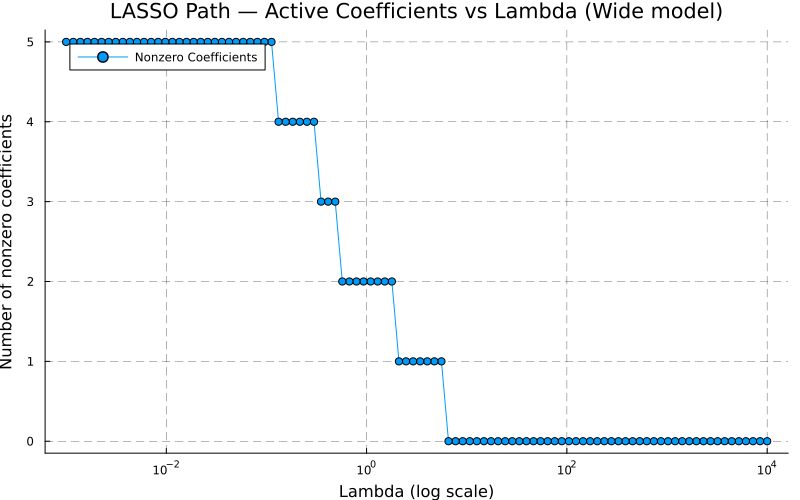

In [125]:
using StatsBase          # ZScoreTransform (estandarización)
using GLMNet             # LASSO
using Plots              # gráficos
using Printf
using Random
using LinearAlgebra

# --------------------------------------------------------------------
# 0️⃣ Entrenamiento / prueba ya definidos en celdas previas:
#      X_train, X_test :: Matrix{Float64}
#      y_train, y_test :: Vector{Float64}
# --------------------------------------------------------------------
# Asegúrate de que todo esté en Float64
Xtr_raw = Matrix{Float64}(X_train)
Xte_raw = Matrix{Float64}(X_test)
ytr     = Vector{Float64}(y_train)

# 1️⃣ Estandarizar con las medias y desviaciones del set de entrenamiento
zt = fit(ZScoreTransform, Xtr_raw; dims=1)
Xtr = StatsBase.transform(zt, Xtr_raw)
Xte = StatsBase.transform(zt, Xte_raw)

# 2️⃣ Grid de lambdas de 10^4 a 10^-3 (escala log)
lambdas = 10 .^ range(4, -3; length=100)

# 3️⃣ Contar coeficientes distintos de cero para cada λ
nonzeros = Int[]
for landa in lambdas
    fitlanda = glmnet(
        Xtr, ytr,
        Normal();              # modelo gaussiano
        alpha = 1.0,           # LASSO puro
        lambda = [landa],      # ⚡️ solo lambda, sin nlambda
        standardize = false,   # ya estandarizamos manualmente
        intercept = true,
        maxit = 20_000,
        tol = 1e-3
    )
    veta = fitlanda.betas[:, 1]  # Extract coefficients for the single lambda
    push!(nonzeros, count(!=(0.0), veta))  # Count nonzero coefficients
end

# 4️⃣ Graficar
plot(
    lambdas, nonzeros;
    xscale = :log10,
    marker = :circle,
    markersize = 4,
    linewidth = 1,
    xlabel = "Lambda (log scale)",
    ylabel = "Number of nonzero coefficients",
    title = "LASSO Path — Active Coefficients vs Lambda (Wide model)",
    grid = true,
    gridstyle = :dash,
    gridalpha = 0.6,
    size = (800, 500),  # Approximates 8x5 inches at ~100 DPI
    legend = :topleft,
    label = "Nonzero Coefficients"
)

# 5️⃣ Información
@printf("Total candidate features: %d\n", size(Xtr, 2))
@printf("Nonzeros at λ=%.0f: %d\n", lambdas[1], nonzeros[1])
@printf("Nonzeros at λ=%.3f: %d\n", lambdas[end], nonzeros[end])
# 6️⃣ Explicitly display the plot (optional, depending on environment)
display(Plots.plot!())